In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [35]:
import pandas as pd
import numpy as np
# from library.lib_aws import AddData
from library.lib_dyna import CardFunctions
from config import username, password, endpoint, data_path
import boto3

# PLotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Options
mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')
pd.set_option('display.max_rows', 1000)

In [3]:
import sqlalchemy
from sqlalchemy.orm import Session
# from config import username, password, endpoint
from io import StringIO 
import csv
import time
from geoalchemy2 import Geometry
import sys
import os

# Helps with relative imports from outside
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# DataBase Classes
class PostgresRDS(object):
    """
    Class Connects to a PostgreSQL DB with password access
    Need to input the database that needs to be connected to
    Note Set the username, password and endpoint in the config file via env variables
    """

    def __init__(self, db, verbose=0):
        self.engine = None
        self.Session = None
        self.db = db
        self.vprint = print if verbose != 0 else lambda *a, **k: None

    def connect(self):
        """
        Connects to the db and gives us the engine
        :return: engine
        """
        engine_config = {
            'sqlalchemy.url': 'postgresql+psycopg2://{user}:{pw}@{host}/{db}'.format(
                user=username,
                pw=password,
                host=endpoint,
                db=self.db
            ),
            'sqlalchemy.pool_pre_ping': True,
            'sqlalchemy.pool_recycle': 3600
        }

        engine = sqlalchemy.engine_from_config(engine_config, prefix='sqlalchemy.')
        self.Session = Session(engine)

        return engine

    def __enter__(self):
        self.engine = self.connect()
        self.vprint("Connected to {} DataBase".format(self.db))
        return self.engine

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.Session.close()
        self.engine.dispose()
        self.vprint("Connection Closed")


class AddData:
    """
    Class which has methods to add data into a postgres db
    """

    @staticmethod
    def psql_insert_copy(table, conn, keys, data_iter):
        """
        Execute SQL statement inserting data

        Parameters
        ----------
        table : pandas.io.sql.SQLTable
        conn : sqlalchemy.engine.Engine or sqlalchemy.engine.Connection
        keys : list of str
            Column names
        data_iter : Iterable that iterates the values to be inserted
        """
        # gets a DBAPI connection that can provide a cursor
        dbapi_conn = conn.connection
        with dbapi_conn.cursor() as cur:
            s_buf = StringIO()
            writer = csv.writer(s_buf)
            writer.writerows(data_iter)
            s_buf.seek(0)

            columns = ', '.join('"{}"'.format(k) for k in keys)
            if table.schema:
                table_name = '{}.{}'.format(table.schema, table.name)
            else:
                table_name = table.name

            sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
                table_name, columns)
            cur.copy_expert(sql=sql, file=s_buf)

    @staticmethod
    def add_data(df, db, table, schema=None, merge_type='append', card_col=None, index_col=None):
        """
        Method to add data to a postgres db
        :param df: Data in the form of a pandas DataFrame
        :param db: Database Name (str)
        :param table: Table Name (str)
        :param schema: Schema Name (Default is None, in this case will add to the public schema)
        :param merge_type: How to add data. Either 'append' or 'replace'. Default: 'append'
        :param card_col: If Card Columns are present. Default('None')
        :param index_col: If an index column is needed. Default('None')
        :return:
        """
        t0 = time.time()
        if card_col is not None:
            dtype_dict = {i: Geometry("POLYGON") for i in card_col}
        else:
            dtype_dict = None

        if index_col is not None:
            try:
                df.set_index(index_col, inplace=True)
            except KeyError:  # Index Column is already set
                pass

        with PostgresRDS(db=db) as engine:
            try:
                df.to_sql(table, con=engine, schema=schema, if_exists=merge_type, method=AddData.psql_insert_copy,
                          dtype=dtype_dict)
            except Exception as e:
                print(e)
                print("Data Not Added")
                return False

        t1 = time.time()
        print("Data {}ed on Table {} in time {:.2f}s".format(merge_type, table, t1 - t0))
        return True


# Hourly Imports

In [5]:
"""
Test out different conditions
1. Finding out a min_time condition to remove repeatable values
"""
local_file_path = r'C:\Users\rai_v\OneDrive\Python Coursera\local-data\oasis'

In [24]:
# XDIAG Rod
str_match = "XDiagRod"
frames = []
for filename in os.listdir(local_file_path):
    if str_match in filename:
        path = os.path.join(local_file_path, filename)
        temp_df = pd.read_csv(path, error_bad_lines=False)
        temp_df.loc[:, 'Date'] = pd.to_datetime(temp_df.loc[:, 'Date'])
        max_time = pd.Timestamp(filename.split('.')[2] + filename.split('.')[3])
        temp_df = temp_df[temp_df['Date'] <= max_time]
        temp_df['ImportDate'] = max_time
        frames.append(temp_df)

data = pd.concat(frames)

In [37]:
"""
Selecting only RodNum 1 and dropping some columns for making the data set smaller
"""
data_cut = data[data.RodNum == 1].copy()
data_cut.sort_values(by=['NodeID', 'Date'], inplace=True)
data_cut.reset_index(inplace=True, drop=True)
data_cut = data_cut[['NodeID', 'Date', 'ImportDate']]
# data_cut.drop(columns = ['Grade', 'Length', 'Diameter', 'RodGuideID', 'DragFrictionCoefficient', 'GuideCountPerRod'], inplace=True)

In [39]:
data_cut.NodeID.unique()

array(['ACADIA 31-25H', 'AK Strangeland 43-12T',
       'AMAZING GRACE FEDERAL 11-2H', 'ANDERSON 7-18H',
       'ANDERSON FEDERAL 14-20H', 'ANDRE 5501 13-4H',
       'ANDRE 5501 14-5 3B', 'ANDRE 5601 42-33 2B', 'ARLYSS 5601 14-26T',
       'ARNSTAD 3-10H', 'AUBREY 5304 41-22H',
       'AUTUMN WIND STATE 5601 14-16B', 'Acklins 12-18H',
       'Aerabelle 5502 43-7T', 'Al 44-23B', 'Alder 43-8H',
       'Amelia Federal 41-11B', 'Anders Madson 14-25 11B',
       'Anders Madson 14-25 12T', 'Anders Madson 14-25 13BX',
       'Anders Madson 42-24 3B', 'Anders Madson 42-24 4T',
       'Anders Madson 42-24 5B', 'Anders Madson 42-24 6T',
       'Anders Madson 43-24 10T', 'Anders Madson 43-24 7B',
       'Anders Madson 43-24 9B', 'Andre Shepherd 5501 21-5 3T',
       'Andre Shepherd 5501 21-5 4T ', 'Andre Shepherd 5501 21-5 5T ',
       'Andre Shepherd 5501 31-8 7T', 'Andy 44-12T', 'Angell 31-28H',
       'Annie 12-18H', 'Annie 12X-18HA', 'Annie 12X-18HB',
       'Annie 5502 43-7B', 'Annie Erie 44

In [44]:
data_cut['Time Diff'] = data_cut.ImportDate - data_cut.Date

In [49]:
data_cut[data_cut.NodeID == "ACADIA 31-25H"]

,NodeID,Date,ImportDate,Time Diff
0,ACADIA 31-25H,2020-08-12 04:22:38,2020-08-13 09:00:00,1 days 04:37:22
1,ACADIA 31-25H,2020-08-12 05:22:37,2020-08-13 10:00:00,1 days 04:37:23
2,ACADIA 31-25H,2020-08-12 06:22:35,2020-08-13 12:00:00,1 days 05:37:25
3,ACADIA 31-25H,2020-08-12 07:22:34,2020-08-13 12:00:00,1 days 04:37:26
4,ACADIA 31-25H,2020-08-12 08:22:32,2020-08-13 13:00:00,1 days 04:37:28
5,ACADIA 31-25H,2020-08-12 09:22:42,2020-08-13 15:00:00,1 days 05:37:18
6,ACADIA 31-25H,2020-08-12 10:22:41,2020-08-13 16:00:00,1 days 05:37:19
7,ACADIA 31-25H,2020-08-12 11:22:41,2020-08-13 17:00:00,1 days 05:37:19
8,ACADIA 31-25H,2020-08-12 13:22:43,2020-08-13 19:00:00,1 days 05:37:17
9,ACADIA 31-25H,2020-08-12 14:23:09,2020-08-13 20:00:00,1 days 05:36:51


In [53]:
tdiff = data_cut['Time Diff']

<AxesSubplot:xlabel='Time Diff'>

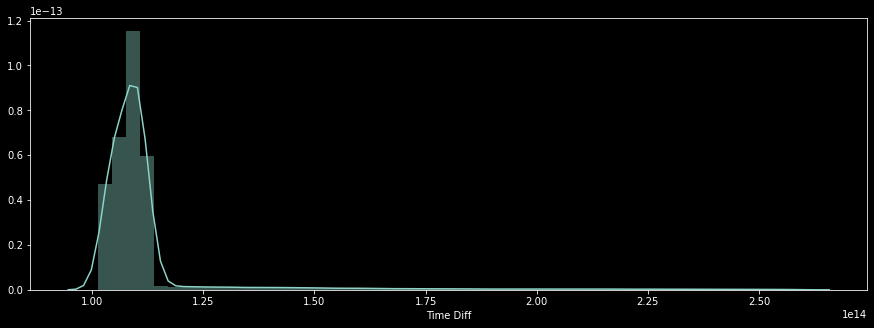

In [67]:
x = tdiff[tdiff <= pd.Timedelta('3 days')]

sns.distplot(x)

In [48]:
data_cut.to_csv("new_xdiagrod_sampled.csv")

In [9]:
# XdiagRod
file1 = 'XDiagRodResults.E2E.20200815.2300.csv'

tmax1 = pd.Timestamp(file1.split('.')[2] + file1.split('.')[3])
xrod1 = pd.read_csv(os.path.join(local_file_path, file1), parse_dates=['Date'])
xrod1.head()

,NodeID,Date,RodNum,Grade,Length,Diameter,Loading,BottomMinStress,TopMinStress,TopMaxStress,RodGuideID,DragFrictionCoefficient,GuideCountPerRod
0,Luke 14-12H,2001-11-18 21:07:37,1,D (API),3225,1.000,102.278161,13316.196289,22291.876953,39610.480469,0,0.0,0
1,Luke 14-12H,2001-11-18 21:07:37,2,D (API),3400,0.875,98.934227,7609.459473,15598.760742,35434.406250,0,0.0,0
2,Luke 14-12H,2001-11-18 21:07:37,3,D (API),3436,0.750,99.362373,-1054.390137,6517.193359,30640.322266,0,0.0,0
3,Luke 14-12H,2001-11-18 21:07:37,4,"K (API, Sinker Bar)",400,1.500,54.760659,-1014.414490,-3003.164795,9467.669922,0,0.0,0
4,Doris H 44-20B,2020-06-27 10:27:29,1,Norris D90,3750,1.000,64.979130,16428.822266,27479.054688,37684.070312,0,0.0,0


In [12]:
file2 = 'XDiagRodResults.E2E.20200816.0000.csv'

tmax2 = pd.Timestamp(file2.split('.')[2] + file2.split('.')[3])
xrod2 = pd.read_csv(os.path.join(local_file_path, file2), parse_dates=['Date'])
xrod2.head()

,NodeID,Date,RodNum,Grade,Length,Diameter,Loading,BottomMinStress,TopMinStress,TopMaxStress,RodGuideID,DragFrictionCoefficient,GuideCountPerRod
0,SAGE BRUSH 2758 41-9 3T,2020-08-14 12:45:45,2,Norris D90,3050,0.875,76.094800,9706.155273,17001.250000,34169.722656,0,0.0,0
1,SAGE BRUSH 2758 41-9 3T,2020-08-14 12:45:45,3,Norris D90,3422,0.750,85.101891,2239.236572,9546.561523,31522.746094,0,0.0,0
2,SAGE BRUSH 2758 41-9 3T,2020-08-14 12:45:45,4,"K (API, Sinker Bar)",425,1.500,49.254444,-238.650208,-1178.995728,10157.313477,0,0.2,0
3,Tufto 5501 14-13 8T,2020-08-14 17:21:56,1,Tenaris MMS-NR,3312,1.000,67.367905,11812.083984,21056.835938,45874.820312,0,0.0,0
4,Tufto 5501 14-13 8T,2020-08-14 17:21:56,2,Tenaris MMS-NR,3300,0.875,71.023732,6735.391602,13373.577148,42948.933594,0,0.0,0


In [21]:
xrod1.sort_values(by=['Date'], ascending=False).head(10)

,NodeID,Date,RodNum,Grade,Length,Diameter,Loading,BottomMinStress,TopMinStress,TopMaxStress,RodGuideID,DragFrictionCoefficient,GuideCountPerRod
2110,Thorlaksen 11-14H,2020-08-14 17:09:36,4,Norris K (sinker bar),375,1.500,69.338191,-291.156281,-1566.677246,13760.172852,0,0.0,0
2109,Thorlaksen 11-14H,2020-08-14 17:09:36,3,Norris 96,2566,0.750,67.602301,1201.551514,4926.527344,34893.644531,0,0.0,0
2108,Thorlaksen 11-14H,2020-08-14 17:09:36,2,Norris 96,2750,0.875,60.138226,6354.745117,11653.056641,35707.351562,0,0.0,0
2107,Thorlaksen 11-14H,2020-08-14 17:09:36,1,Norris 96,2850,1.000,55.824834,10315.884766,18169.126953,38156.441406,0,0.0,0
2106,DAD FRYE FEDERAL 2758 24-32B,2020-08-14 17:09:09,4,"K (API, Sinker Bar)",225,1.500,35.731241,-4305.042969,-11513.853516,-1960.700195,0,0.0,0
2105,DAD FRYE FEDERAL 2758 24-32B,2020-08-14 17:09:09,3,Norris D90,3477,0.750,55.931854,-16249.416016,-8545.683594,9620.470703,0,0.0,0
2104,DAD FRYE FEDERAL 2758 24-32B,2020-08-14 17:09:09,2,Norris D90,2875,0.875,53.045481,-3650.790039,3129.423096,17474.439453,0,0.0,0
2103,DAD FRYE FEDERAL 2758 24-32B,2020-08-14 17:09:09,1,Norris D90,2864,1.000,52.724409,3707.281982,12160.710938,24201.736328,0,0.0,0
2101,Van Berkom 5793 11-14H,2020-08-14 17:09:06,3,Norris D90,3700,0.750,85.115629,1142.520020,8110.794434,29154.283203,0,0.0,0
2102,Van Berkom 5793 11-14H,2020-08-14 17:09:06,4,"K (API, Sinker Bar)",435,1.250,54.576194,15.315878,-1964.371948,10200.476562,0,0.0,0


In [18]:
xrod2[xrod2.Date <= tmax2].sort_values(by=['Date', "NodeID", "RodNum"], ascending=False)

,NodeID,Date,RodNum,Grade,Length,Diameter,Loading,BottomMinStress,TopMinStress,TopMaxStress,RodGuideID,DragFrictionCoefficient,GuideCountPerRod
1439,Anders Madson 42-24 6T,2020-08-14 18:11:25,3,"K (API, Sinker Bar)",525,1.500,62.699294,-321.418518,-1493.932983,13023.208008,0,0.2,0
1438,Anders Madson 42-24 6T,2020-08-14 18:11:25,2,Norris D90,6228,0.875,115.640581,2800.116211,17870.828125,43521.656250,0,0.0,0
1437,Anders Madson 42-24 6T,2020-08-14 18:11:25,1,Norris D90,3225,1.000,115.850365,15375.152344,23361.398438,46275.890625,0,0.0,0
1490,Inigo 43-20B,2020-08-14 18:11:22,3,"K (API, Sinker Bar)",475,1.500,38.505623,-1070.997559,-2785.919434,5944.149902,0,0.0,0
1489,Inigo 43-20B,2020-08-14 18:11:22,2,Norris D90,6126,0.875,63.324142,474.851776,17356.308594,30286.128906,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,Kelter 7-6 HTF2,2020-04-06 09:20:34,1,Norris D90,2750,1.000,76.634824,15094.393555,22752.789062,38114.742188,0,0.0,0
170,Luke 14-12H,2001-11-18 22:10:30,4,"K (API, Sinker Bar)",400,1.500,53.090364,-952.433899,-2745.300537,9281.409180,0,0.0,0
169,Luke 14-12H,2001-11-18 22:10:30,3,D (API),3436,0.750,95.262170,-595.964783,7311.665527,30086.949219,0,0.0,0
168,Luke 14-12H,2001-11-18 22:10:30,2,D (API),3400,0.875,95.851314,8193.153320,16146.874023,35119.789062,0,0.0,0


# Generalizing

In [4]:
db = 'oasis-dev'
schema = 'stream'

class OasisStream:

    def __init__(self, str_match, table_name, file_path=data_path,
                 date_col='Date', well_col='NodeID', drop_cols=None):
        self.str_match = str_match
        self.table_name = table_name

        self.file_path = file_path
        self.date_col = date_col
        self.well_col = well_col

        self.drop_cols = drop_cols

        self.files = []
        self.add_success = False
        self.transfer_success = False
        self.del_success = False

    def add_to_db(self):
        """
        Imports data from the files and adds it to the database
        """
        frames = []
        for filename in os.listdir(self.file_path):
            if self.str_match in filename:
                self.files.append(filename)
                path = os.path.join(self.file_path, filename)
                temp_df = pd.read_csv(path, error_bad_lines=False)
                temp_df.loc[:, self.date_col] = pd.to_datetime(temp_df.loc[:, self.date_col])
                max_time = pd.Timestamp(filename.split('.')[2] + filename.split('.')[3])
                temp_df = temp_df[temp_df[self.date_col] <= max_time]
                frames.append(temp_df)
                print(filename)
                print(max_time)
        
        try:
            data = pd.concat(frames)
        except ValueError:
            return print("Files were not there")
        
        if self.drop_cols is not None:
            data.drop(columns=self.drop_cols, inplace=True)
        
        # Duplicates Drop
        dup_cols = [self.well_col, self.date_col]
        if self.str_match == 'XDiagRod':
            dup_cols.append('RodNum')
        data.drop_duplicates(subset=dup_cols, inplace=True)
        
        data.sort_values(by=[self.well_col, self.date_col], inplace=True)
        data.reset_index(inplace=True, drop=True)

        self.add_success = AddData.add_data(df=data, db=db, schema=schema,
                                            table=self.table_name, merge_type='append',
                                            index_col=self.date_col)

    def transfer_s3(self, location):
        s3 = boto3.resource('s3')

        if self.add_success is False:
            return print("Data hasn't been added to RDS DB")

        for filename in self.files:
            s3.meta.client.upload_file(os.path.join(self.file_path, filename),
                                       "et-oasis", location + filename)
        self.transfer_success = True

    def del_files(self):

        if self.transfer_success is False:
            return print("First Transfer the files")
        if self.add_success is False:
            return print("Add Data to db first")

        for filename in self.files:
            os.remove(os.path.join(self.file_path, filename))
            
        self.del_success = True
        
        return None
            
    def result(self):
        print('Files Worked on:',*self.files, sep='\n')
        print(f'Data added to DB                    : {self.add_success}')
        print(f'Files Transfered to S3              : {self.transfer_success}')
        print(f'Files deleted from {self.file_path} : {self.del_success}')

In [9]:
xdiagrod = OasisStream(str_match='XDiagRod', table_name='xdiagrod_test')
xdiagrod.add_to_db()
xdiagrod.transfer_s3(location="backup/xdiagRodResults/")
xdiagrod.result()

In [22]:
xr_cols_drop = [
    'PumpCond1',
    'PumpCond2',
    'MonthlyElecCost',
    'MinEnergyElecBO',
    'MinTorqueElecBO',
    'CurrentElecBO',
    'AvgDHDSLoad',
    'AvgDHUSLoad',
    'AvgDHDSPOLoad',
    'AvgDHUSPOLoad',
    'DownholeAnalysisLocale',
    'RodAnalysisLocale',
    'SurfaceAnalysisLocale',
    'InputAnalysisLocale'
]

In [23]:
xdiagres = OasisStream(str_match='XDiagResults', table_name='xdiagresults_test', drop_cols=xr_cols_drop)
xdiagres.add_to_db()
xdiagres.transfer_s3(location="backup/xdiagresults/")
xdiagres.result()

XDiagResults.E2E.20200810.1600.csv
2020-08-10 16:00:00
XDiagResults.E2E.20200810.1700.csv
2020-08-10 17:00:00
Data appended on Table xdiagresults_test in time 10.91s
Files Worked on:
XDiagResults.E2E.20200810.1600.csv
XDiagResults.E2E.20200810.1700.csv
Data added to DB                    : True
Files Transfered to S3              : True
Files deleted from C:\Users\rai_v\OneDrive\Python Coursera\local-data\oasis : False


In [25]:
welltest = OasisStream(str_match='WellTests', table_name='welltest_test', date_col='TestDate')
welltest.add_to_db()
welltest.transfer_s3(location="backup/wellTests/")
# welltest.del_files()
welltest.result()

WellTests.E2E.20200807.1100.csv
2020-08-07 11:00:00
Data appended on Table welltest_test in time 5.58s
Files Worked on:
WellTests.E2E.20200807.1100.csv
Data added to DB                    : True
Files Transfered to S3              : True
Files deleted from C:\Users\rai_v\OneDrive\Python Coursera\local-data\oasis : False


## Card Data

In [ ]:
def get_dyna(card_arr):
    """
    Transforms Hexadecimal Dyna Card Value into Position and Load value
    :param card_arr: Hexadecimal Array
    :return: Position, Load 2D array
    """
    if pd.isnull(card_arr):
        pos = [0, 0, 0]
        load = [0, 0, 0]

    else:
        test_card = card_arr.strip()
        mid = len(test_card) / 2
        mid = int(mid)

        load = []
        pos = []

        for i in range(0, mid, 8):
            load_temp = test_card[i:i + 8]
            load_int = struct.unpack('f', bytes.fromhex(load_temp))[0]
            load.append(load_int)

            pos_temp = test_card[mid + i:mid + i + 8]
            pos_int = struct.unpack('f', bytes.fromhex(pos_temp))[0]
            pos.append(pos_int)

    return np.column_stack(([pos, load]))


def hex_to_wkb(card_arr):
    """
    Transforms the Hexadecimal based card into a WKB element
    Helps store the data in a postgis db
    :param card_arr: Hexadecimal Card Value
    :return: WKB card value
    """
    xy = CardFunctions.get_dyna(card_arr)

    try:
        polygon = Polygon(xy)
        wkb_element = from_shape(polygon)
    except Exception as e:
        print(e)
        wkb_element = np.nan

    return wkb_element

## Backed up Data

### Card Data

In [ ]:
import struct
from geoalchemy2.shape import from_shape
from shapely.geometry import Polygon
from shapely.wkb import loads
from pyefd import elliptic_fourier_descriptors

In [ ]:
local_file_path = r'C:\Users\rai_v\OneDrive\Python Coursera\local-data\oasis'
file_name = 'CardData.E2E.20200728.1100.csv'
time_max = pd.Timestamp(file_name.split('.')[2] + file_name.split('.')[3])

In [ ]:
# global 
cols_to_drop = [
    'SurfaceCard',
    'DownholeCard',
    'PredictedCard',
    'PocDHCard',
    'CorrectedCard',
    'TorquePlotMinEnergy',
    'TorquePlotMinTorque',
    'TorquePlotCurrent',
    'POCDownholeCard',
    'ElectrogramCardB'
]

In [ ]:
%%time
data = pd.read_csv(os.path.join(local_file_path, file_name), parse_dates=['Date'], usecols=['NodeID', 'Date', 'POCDownholeCardB', 'SurfaceCardB'])
# data.drop(columns=cols_to_drop, inplace=True)
data = data[data.Date <= time_max]  # Drop points which are greater than the import timestamp
data.sort_values(by=['NodeID', 'Date'], inplace=True)
data.reset_index(inplace=True, drop=True)
data.tail(10)

In [ ]:
np.round(data.isnull().sum(axis=0)/len(data) * 100)

In [ ]:
"""
Test 
"""
# Convert columns
data_test = data.loc[0:10].copy()

card_cols = [
    'SurfaceCardB',
    'POCDownholeCardB'
]

for c in card_cols:
    data_test.loc[:,c] = data_test.loc[:,c].apply(hex_to_wkb)
    
display(data_test.head())

# Adding data to db
AddData.add_data(df=data_test, db='oasis-dev', table='testcards', schema='stream', merge_type='replace', card_col=card_cols, index_col='Date')

In [ ]:
"""
For entire data
"""
card_cols = [
    'SurfaceCardB',
    'POCDownholeCardB'
]

for c in card_cols:
    print(c)
    data.loc[:, c] = data.loc[:, c].apply(hex_to_wkb)
  

In [ ]:
data.head()

In [ ]:
AddData.add_data(df=data, db='oasis-dev', table='testcards', schema='stream', merge_type='replace', card_col=card_cols, index_col='Date') 

### Test Data

In [ ]:
frames = []
files = []
for filename in os.listdir(data_path):
    if 'WellTests' in filename:
        files.append(filename)
        path = os.path.join(data_path, filename)
        print(path)
        temp_df = pd.read_csv(path, error_bad_lines=False)
        frames.append(temp_df)

try:
    df = pd.concat(frames)
except ValueError:
    print("Files were not Present")
    


### XDiagRod

We have 2 file to use
- XDiagRodResults.E2E.20200728.1123  --> Which has data from May 25th to July 28th
- XDiagRodResults.E2E.20200810.1503  --> Which has data from July 28th to Aug 10

In [ ]:
# Xdiagrod Results
file_path = r"C:\Users\rai_v\OneDrive\Python Coursera\local-data\oasis\back"

file1 = 'XDiagRodResults.E2E.20200810.1503.csv'
tmax1 = pd.Timestamp(file1.split('.')[2] + file1.split('.')[3])

file2 = 'XDiagRodResults.E2E.20200728.1123.csv'
tmax2 = pd.Timestamp(file2.split('.')[2] + file2.split('.')[3])

In [ ]:
xdiag1 = pd.read_csv(os.path.join(file_path, file1), error_bad_lines=False, parse_dates=['Date'])
print(f"# initial: {len(xdiag1)}")
xdiag1 = xdiag1[xdiag1.Date <= tmax1]
print(f"# removing bad dates: {len(xdiag1)}")
xdiag1.sort_values(by=['NodeID', 'Date'], inplace=True)
xdiag1.drop_duplicates(subset=['NodeID', 'Date', 'RodNum'], inplace=True)
print(f"# removing duplicates: {len(xdiag1)}")
xdiag1.reset_index(inplace=True, drop=True)
xdiag1.groupby("NodeID").agg({"Date": [min, max, "count"]})

In [ ]:
xdiag2 = pd.read_csv(os.path.join(file_path, file2), error_bad_lines=False, parse_dates=['Date'])
print(f"# initial: {len(xdiag2)}")
xdiag2 = xdiag2[xdiag2.Date <= tmax2]
print(f"# removing bad dates: {len(xdiag2)}")
xdiag2.sort_values(by=['NodeID', 'Date'], inplace=True)
xdiag2.drop_duplicates(subset=['NodeID', 'Date', 'RodNum'], inplace=True)
print(f"# removing duplicates: {len(xdiag2)}")
xdiag2.reset_index(inplace=True, drop=True)
xdiag2.groupby("NodeID").agg({"Date": [min, max, "count"]})['Date']

In [ ]:
# Merge the data
xdiagrod = pd.concat([xdiag2, xdiag1])
xdiagrod.sort_values(by=['NodeID', 'Date'], inplace=True)
print(f'Size is {len(xdiagrod)}')
xdiagrod.drop_duplicates(subset=['NodeID', 'Date', 'RodNum'], inplace=True)
print(f'Size is {len(xdiagrod)}')
xdiagrod.reset_index(inplace=True, drop=True)

In [ ]:
xdiagrod.head()

In [ ]:
AddData.add_data(df=xdiagrod, db='oasis-dev', table='xdiagrod', schema='stream', merge_type='replace', card_col=None, index_col='Date') 

## XDiagResults

In [ ]:
# Xdiag Results
file_path = r"C:\Users\rai_v\OneDrive\Python Coursera\local-data\oasis\back"

file1 = 'XDiagResults.E2E.20200728.1116.csv'
tmax1 = pd.Timestamp(file1.split('.')[2] + file1.split('.')[3])

file2 = 'XDiagResults.E2E.20200810.1500.csv'
tmax2 = pd.Timestamp(file2.split('.')[2] + file2.split('.')[3])

In [ ]:
xdiag1 = pd.read_csv(os.path.join(file_path, file1), error_bad_lines=False, parse_dates=['Date'])
print(f"# initial: {len(xdiag1)}")
xdiag1 = xdiag1[xdiag1.Date <= tmax1]
print(f"# removing bad dates: {len(xdiag1)}")
xdiag1.sort_values(by=['NodeID', 'Date'], inplace=True)
xdiag1.drop_duplicates(subset=['NodeID', 'Date'], inplace=True)
print(f"# removing duplicates: {len(xdiag1)}")
xdiag1.reset_index(inplace=True, drop=True)
xdiag1.groupby("NodeID").agg({"Date": [min, max, "count"]})

In [ ]:
xdiag2 = pd.read_csv(os.path.join(file_path, file2), error_bad_lines=False, parse_dates=['Date'])
print(f"# initial: {len(xdiag2)}")
xdiag2 = xdiag2[xdiag2.Date <= tmax2]
print(f"# removing bad dates: {len(xdiag2)}")
xdiag2.sort_values(by=['NodeID', 'Date'], inplace=True)
xdiag2.drop_duplicates(subset=['NodeID', 'Date'], inplace=True)
print(f"# removing duplicates: {len(xdiag2)}")
xdiag2.reset_index(inplace=True, drop=True)
xdiag2.groupby("NodeID").agg({"Date": [min, max, "count"]})['Date']

In [ ]:
# Merge the data
xr = pd.concat([xdiag2, xdiag1])
xr.sort_values(by=['NodeID', 'Date'], inplace=True)
print(f'Size is {len(xr)}')
xr.drop_duplicates(subset=['NodeID', 'Date'], inplace=True)
print(f'Size is {len(xr)}')
xr.reset_index(inplace=True, drop=True)

In [ ]:
# list of columns with only null vales
xr_null = xr.isnull().sum(axis=0)/len(xr)
xr_null[xr_null == 1].index.to_list()

In [ ]:
xr_cols_drop = [
    'PumpCond1',
    'PumpCond2',
    'MonthlyElecCost',
    'MinEnergyElecBO',
    'MinTorqueElecBO',
    'CurrentElecBO',
    'AvgDHDSLoad',
    'AvgDHUSLoad',
    'AvgDHDSPOLoad',
    'AvgDHUSPOLoad',
    'DownholeAnalysisLocale',
    'RodAnalysisLocale',
    'SurfaceAnalysisLocale',
    'InputAnalysisLocale'
]
xr.drop(columns = xr_cols_drop, inplace=True)

In [ ]:
xr.sort_values(by=['NodeID', 'Date'], inplace=True)
xr.reset_index(inplace=True, drop=True)
xr.tail()

In [ ]:
AddData.add_data(df=xr, db='oasis-dev', table='xdiagresults', schema='stream', merge_type='replace', card_col=None, index_col='Date') 

## Well Tests

In [ ]:
# Card Data
file_path = r"C:\Users\rai_v\OneDrive\Python Coursera\oasis\data\back\WellTests.E2E.20200728.1116.csv"
well_test = pd.read_csv(file_path, parse_dates=['TestDate'])
display(well_test.isnull().sum(axis=0)/well_test.shape[0] * 100)
display(well_test.head())


In [ ]:
pd.Timestamp